In [1]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from adjustText import adjust_text
plt.style.use(["science", "scatter", "no-latex"])

In [2]:
# regex patterns
PATTERNS = {
    "Status": re.compile(r"^\s*Status\s*:\s*(\S+)"),
    "Precondition time": re.compile(r"^\s*Precondition time\s*:\s*([\deE\+\-\.]+)"),
    "Iterations": re.compile(r"^\s*Iterations\s*:\s*(\d+)"),
    "Solve time": re.compile(r"^\s*Solve time\s*:\s*([\deE\+\-\.]+)"),
    "Primal objective": re.compile(r"^\s*Primal objective\s*:\s*([\deE\+\-\.]+)"),
    "Dual objective": re.compile(r"^\s*Dual objective\s*:\s*([\deE\+\-\.]+)")
}

## Parse Summary

In [4]:
def parse_slurm_file(path):
    """
    Parse a single slurm file
    """
    # init result
    results = {}
    current_instance = None

    # read lines
    with open(path, "r") as f:
        lines = f.readlines()

    # get info
    for line in lines:
        # detect a new instance
        m = re.search(r"^Instance:\s+(\S+)", line)
        if m:
            # init info for current instance
            current_instance = m.group(1)
            results[current_instance] = {
                "Status": None,
                "Precondition time": None,
                "Iterations": None,
                "Solve time": None,
                "Primal objective": None,
                "Dual objective": None,
            }
            continue

        # skip if not an instance
        if current_instance is None:
            continue

        # match field
        for field, pat in PATTERNS.items():
            m = pat.search(line)
            # store info
            if m:
                value = m.group(1)
                results[current_instance][field] = m.group(1)

    return results

In [5]:
def load_benchmark(job_id):
    """
    Parse *.out files for a job id, merge their results, and return a pandas DataFrame
    """
    # files dir
    f1 = f".\\slurm\\slurm-c-vtx-benchmark-{job_id}_1.out"
    f2 = f".\\slurm\\slurm-c-vtx-benchmark-{job_id}_2.out"

    # existence check
    if not os.path.exists(f1) or not os.path.exists(f2):
        raise FileNotFoundError("Some slurm files not found.")

    # parse files
    r1 = parse_slurm_file(f1)
    r2 = parse_slurm_file(f2)

    # merrge the two results
    merged = merge_results(r1, r2)

    # convert to a DataFrame
    df = pd.DataFrame.from_dict(merged, orient="index")
    df.index.name = "Instance"
    return df

def merge_results(res1, res2):
    """
    Merge the parsed results from two files.
    """
    # init merged results
    merged = {}
    # union instance
    all_instances = set(res1.keys()) | set(res2.keys())

    for inst in all_instances:
        # instance existence check
        if inst not in res1 or inst not in res2:
            print(f"[WARNING] Instance {inst} missing in one file.")
            continue

        # get per-instance records
        r1, r2 = res1[inst], res2[inst]
        # init field for current instance
        merged[inst] = {}

        # numeric average
        #merged[inst]["Precondition time"] = (float(r1["Precondition time"]) + float(r2["Precondition time"])) / 2
        merged[inst]["Solve time"] = (float(r1["Solve time"]) + float(r2["Solve time"])) / 2
        # check consistency for others
        for field in ["Status", "Iterations", "Primal objective", "Dual objective"]:
            v1 = r1[field]
            v2 = r2[field]
            if v1 != v2:
                print(f"[WARNING] mismatch in {field} for instance {inst}: {v1} vs {v2}")
            merged[inst][field] = v1
    return merged


In [6]:
def load_two_jobs(job1, job2):
    """
    Load and merge results from two benchmarks
    """
    # load per-job benchmark results
    df1 = load_benchmark(job1)
    df2 = load_benchmark(job2)

    # find duplicated instances
    overlap = df1.index.intersection(df2.index)
    for inst in overlap:
        print(f"[WARNING] duplicate instance '{inst}' found in both jobs "
              f"({job1} & {job2}); keeping job {job1}'s entry.")

    # drop duplicated instances from df2
    df2 = df2.drop(index=overlap)

    # concatenate along rows
    df_merged = pd.concat([df1, df2], axis=0)
    return df_merged

In [7]:
df_CPU = load_two_jobs(8067930, 8067931)
df_GPU = load_two_jobs(8057961, 8058021)

[WARNING] mismatch in Iterations for instance ns1687037: 246429000 vs 246716400
[WARNING] mismatch in Primal objective for instance ns1687037: 4.678306582 vs 4.673169033
[WARNING] mismatch in Dual objective for instance ns1687037: -250.390681 vs -250.3499165
[WARNING] mismatch in Iterations for instance neos-4535459-waipa: 7857200 vs 7792000
[WARNING] mismatch in Primal objective for instance neos-4535459-waipa: 3.06017374e+15 vs 3.066264789e+15
[WARNING] mismatch in Dual objective for instance neos-4535459-waipa: -4.356248758e+10 vs -4.32734896e+10
[WARNING] duplicate instance 's100' found in both jobs (8067930 & 8067931); keeping job 8067930's entry.
[WARNING] duplicate instance 'physiciansched3-3' found in both jobs (8067930 & 8067931); keeping job 8067930's entry.
[WARNING] duplicate instance 's250r10' found in both jobs (8067930 & 8067931); keeping job 8067930's entry.
[WARNING] duplicate instance 'stp3d' found in both jobs (8067930 & 8067931); keeping job 8067930's entry.
[WARNIN

## Check Consistency

In [9]:
def check_consistency_obj(df_1, df_2, abs_tol=1e-6):
    """
    Check consistency of key fields between CPU and GPU benchmark results.
    """
    # get instances
    common = df_1.index.intersection(df_2.index)

    # for each instance
    mismatch_count = 0
    for inst in common:
        rC = df_1.loc[inst]
        rG = df_2.loc[inst]

        # comparison with tolerance
        for field in ["Primal objective", "Dual objective"]:
            fC = float(rC[field])
            fG = float(rG[field])
            if abs(fC - fG) > abs_tol:
                print(f"[WARNING] mismatch in {field} for instance {inst}:")
                # print a comparison table
                display_df = pd.DataFrame([rC, rG], index=["Orignal", "Test"])[["Status", "Iterations", "Primal objective", "Dual objective"]]
                print(display_df.to_string())
                print("-" * 60)
                mismatch_count += 1
                break

    print(f"Total mismatches: {mismatch_count} / {len(common)} instances")

In [10]:
check_consistency_obj(df_CPU, df_GPU)

[WARNING] mismatch in Primal objective for instance ns1687037:
             Status Iterations Primal objective Dual objective
Orignal  TIME_LIMIT  246429000      4.678306582    -250.390681
Test     TIME_LIMIT  252143200      4.689183513   -249.5551493
------------------------------------------------------------
[WARNING] mismatch in Primal objective for instance neos-4535459-waipa:
             Status Iterations Primal objective    Dual objective
Orignal  TIME_LIMIT    7857200   3.06017374e+15  -4.356248758e+10
Test     TIME_LIMIT    7895200  3.056019324e+15  -4.372484483e+10
------------------------------------------------------------
Total mismatches: 2 / 414 instances


In [11]:
def check_consistency_iter(df_1, df_2, rel_tol=0.001):
    """
    Check consistency of key fields between CPU and GPU benchmark results.
    """
    # get instances
    common = df_1.index.intersection(df_2.index)

    # for each instance
    mismatch_count = 0
    for inst in common:
        rC = df_1.loc[inst]
        rG = df_2.loc[inst]

        # comparison with tolerance
        for field in ["Primal objective", "Dual objective"]:
            iC = float(rC["Iterations"])
            iG = float(rG["Iterations"])
            rel_diff = abs(iC - iG) / max(iC, iG, 1.0)
            if rel_diff > rel_tol:
                print(f"[WARNING] more than 1% mismatch in Iterations for instance {inst}:")
                # print a comparison table
                display_df = pd.DataFrame([rC, rG], index=["Orignal", "Test"])[["Status", "Iterations", "Primal objective", "Dual objective"]]
                print(display_df.to_string())
                print("-" * 60)
                mismatch_count += 1
                break

    print(f"Total mismatches: {mismatch_count} / {len(common)} instances")

In [12]:
check_consistency_iter(df_CPU, df_GPU)

[WARNING] more than 1% mismatch in Iterations for instance ns1687037:
             Status Iterations Primal objective Dual objective
Orignal  TIME_LIMIT  246429000      4.678306582    -250.390681
Test     TIME_LIMIT  252143200      4.689183513   -249.5551493
------------------------------------------------------------
[WARNING] more than 1% mismatch in Iterations for instance neos-4535459-waipa:
             Status Iterations Primal objective    Dual objective
Orignal  TIME_LIMIT    7857200   3.06017374e+15  -4.356248758e+10
Test     TIME_LIMIT    7895200  3.056019324e+15  -4.372484483e+10
------------------------------------------------------------
Total mismatches: 2 / 414 instances


## Visualization

In [14]:
def plot_comparison(df_1, df_2, log=False):
    """
    CPU vs GPU time comparison.
    """
    # find common instances
    df1 = df_1.copy()
    df2 = df_2.copy()
    common = df1.index.intersection(df2.index)

    # extract times
    cpu_sol = df1["Solve time"].astype(float)
    gpu_sol = df2["Solve time"].astype(float)

    # color palette
    cmap = plt.get_cmap("tab10")
    color_pre = cmap(0)
    color_sol = cmap(1)
    edge_color = "black"

    plt.figure(figsize=(7, 6))
    # scatter points
    plt.scatter(cpu_sol, gpu_sol, s=45, alpha=0.8, color=color_sol, edgecolors=edge_color, linewidth=0.8)
    # y = x line
    max_sol = max(cpu_sol.max(), gpu_sol.max())
    plt.plot([0, max_sol], [0, max_sol], "k--", linewidth=1)
    # label
    plt.title("Time Comparison", fontsize=24, fontweight="bold")
    plt.xlabel("Original Solve Time (sec)", fontsize=18)
    plt.ylabel("Test Solve Time (sec)", fontsize=18)
    # annotate instance
    #texts = []
    #for inst, x, y in zip(common, cpu_sol, gpu_sol):
    #    if (x > 500) and (abs(y - x) / max(x, y, 1e-8) > 0.2):
    #        texts.append(plt.annotate(inst, (x, y), fontsize=10, color="black"))
    #    elif x > 12000:
    #        texts.append(plt.annotate(inst, (x, y), fontsize=10, color="black"))
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray"))
    # Log scale
    if log:
        plt.xscale("log")
        plt.yscale("log")
    # layout
    plt.tick_params(axis="both", which="major", labelsize=16)
    #plt.tight_layout()
    plt.show()

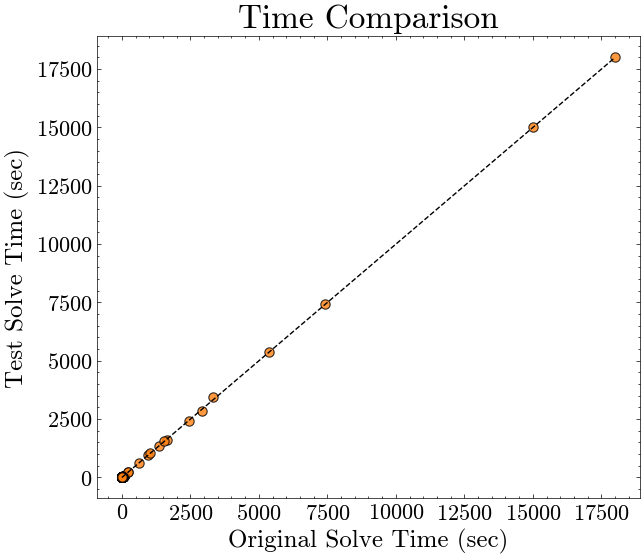

In [15]:
plot_comparison(df_CPU, df_GPU)

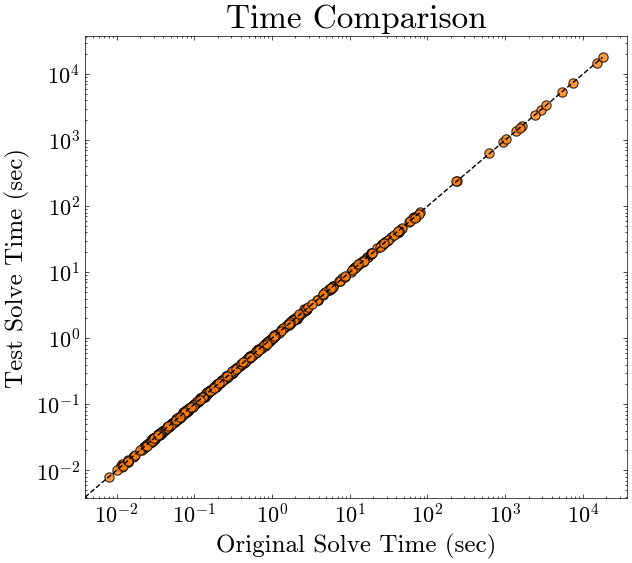

In [16]:
plot_comparison(df_CPU, df_GPU, log=True)